# Stack Overflow Tag Prediction Project
This project aims to predict tags for Stack Overflow questions using machine learning and natural language processing techniques. We will explore the dataset, preprocess the text data, extract features, and build models to predict the tags associated with each question.


In [315]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pylab import rcParams
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, precision_recall_curve, average_precision_score, balanced_accuracy_score, log_loss, matthews_corrcoef, cohen_kappa_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MultiLabelBinarizer
from bs4 import BeautifulSoup
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding, LSTM, Activation, Dense, Dropout, Flatten, BatchNormalization, Input, Bidirectional, GRU
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from wordcloud import WordCloud
import os
import re
import contractions
from datetime import datetime

# Settings and warnings
%matplotlib inline
warnings.filterwarnings('ignore')
rcParams['figure.figsize'] = 10, 10

# NLTK downloads
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')


## Data Loading
In this section, we load the necessary datasets for our analysis, including questions, answers, and tags from Stack Overflow.


In [316]:
def load_datasets(answer_path, question_path, tag_path):
    questions = pd.read_csv(question_path, encoding='ISO-8859-1')
    answers = pd.read_csv(answer_path, encoding='ISO-8859-1')
    tags = pd.read_csv(tag_path)
    return questions, answers, tags

In [317]:
questions, answers, tags = load_datasets('Answers.csv', 'Questions.csv', 'Tags.csv')

In [318]:
def display_head(*dataframes, n=5):
    for df in dataframes:
        display(df.head(n))

## Data Inspection
Here we take an initial look at the data to understand its structure, content, and any potential anomalies that need to be addressed during preprocessing.


In [319]:
display_head(questions, answers, tags)

,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [320]:
print('Shape of Answers dataset:', answers.shape)
print('Shape of Questions dataset:', questions.shape)
print('Shape of Tags dataset:', tags.shape)

Shape of Answers dataset: (2014516, 6)
Shape of Questions dataset: (1264216, 7)
Shape of Tags dataset: (3750994, 2)


## Exploratory Data Analysis (EDA)
EDA helps in uncovering patterns, anomalies, or relationships in the data. We visualize the distribution of tags, the frequency of words, and other relevant aspects to gain insights into the dataset.


In [321]:
print('Number of unique Scores :', questions['Score'].nunique())

questions[questions.Score >= 5].shape

Number of unique Scores : 532


(93153, 7)

In [322]:
# We will build our model on the questions with score >=5

questions = questions[questions.Score >=5]
print(questions.shape)
questions.head()

(93153, 7)


,Id,OwnerUserId,CreationDate,ClosedDate,Score,Title,Body
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...
1,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...
2,120,83.0,2008-08-01T15:50:08Z,NaN,21,ASP.NET Site Maps,<p>Has anyone got experience creating <strong>...
3,180,2089740.0,2008-08-01T18:42:19Z,NaN,53,Function for creating color wheels,<p>This is something I've pseudo-solved many t...
4,260,91.0,2008-08-01T23:22:08Z,NaN,49,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...


In [323]:
# Dropping the following features as they don't seem relevant to our analysis
questions.drop(columns=['OwnerUserId', 'CreationDate', 'ClosedDate', 'Score'], inplace=True)

In [324]:
# We will build our model on top 10 tags
top10_tags = list(tags.Tag.value_counts()[:10].index)
print(top10_tags)

new_tags = tags[tags.Tag.isin(top10_tags)]
print(new_tags.shape)
new_tags.reset_index(drop=True, inplace=True)
new_tags.head()

['javascript', 'java', 'c#', 'php', 'android', 'jquery', 'python', 'html', 'c++', 'ios']
(826739, 2)


,Id,Tag
0,260,c#
1,330,c++
2,650,c#
3,930,c#
4,1010,c#


In [325]:
questions.isnull().sum()

Id       0
Title    0
Body     0
dtype: int64

In [326]:
new_tags.isnull().sum()

Id     0
Tag    0
dtype: int64

In [327]:
# Merging questions dataset with tags dataset
df = questions.merge(new_tags, on='Id')
print(df.shape)
df.head()

(56008, 4)


,Id,Title,Body,Tag
0,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,c#
1,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,c++
2,650,Automatically update version number,<p>I would like the version property of my app...,c#
3,930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,c#
4,1010,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,c#


In [328]:
df.isnull().sum()

Id       0
Title    0
Body     0
Tag      0
dtype: int64

## Checking questions with multiple tags

In [329]:
tagged_questions = df.groupby('Id').agg({
    'Title': 'first',  # Keep the title of the first occurrence
    'Body': 'first',  # Keep the body of the first occurrence
    'Tag': lambda tags: ','.join(tags)  # Join all tags associated with the ID
}).reset_index()

# This adds a new column indicating the number of tags for each question
tagged_questions['Tag_Count'] = tagged_questions['Tag'].apply(lambda x: len(x.split(',')))

# Filter to find questions with more than one tag
multiple_tags = tagged_questions[tagged_questions['Tag_Count'] > 1]

multiple_tags

,Id,Title,Body,Tag,Tag_Count
30,11060,How should I unit test a code-generator?,<p>This is a difficult and open-ended question...,"c++,python",2
32,12870,Arrays of Arrays in Java,<p>This is a nasty one for me... I'm a PHP gu...,"java,php",2
83,33080,Setting the height of a DIV dynamically,"<p>In a web application, I have a page that co...","javascript,html",2
87,34120,HTML Scraping in Php,<p>I've been doing some html scraping in PHP u...,"php,html",2
89,34790,duplicating jQuery datepicker,<p>The <code>datepicker</code> function only w...,"javascript,jquery",2
...,...,...,...,...,...
50801,39851050,Android Studio 2.2 and Jack are getting blocke...,<p>So I update my project to use the new jack ...,"java,android",2
50810,39889070,Getting radio button value and storing in php,<p>this is radio button code \nnow what if rad...,"php,html",2
50816,39922210,How to resize Webview height based on HTML con...,<p>I am currently working on Windows 10 UWP Ap...,"javascript,c#",2
50831,39990020,How to hide navbar when when overlay appears,"<p>Using code from <a href=""http://www.w3schoo...","javascript,html",2


## Exploring top 10 tags

In [330]:
df_copy = df.copy()

In [331]:
df_copy['Tag'] = df_copy['Tag'].str.split(',')

In [332]:
df_exploded = df_copy.explode('Tag')

In [333]:
top_tags = df_exploded['Tag'].value_counts().head(10)
print(top_tags)

Tag
c#            8909
java          8695
javascript    7118
android       6376
python        5667
c++           5518
php           3993
jquery        3599
ios           3438
html          2695
Name: count, dtype: int64


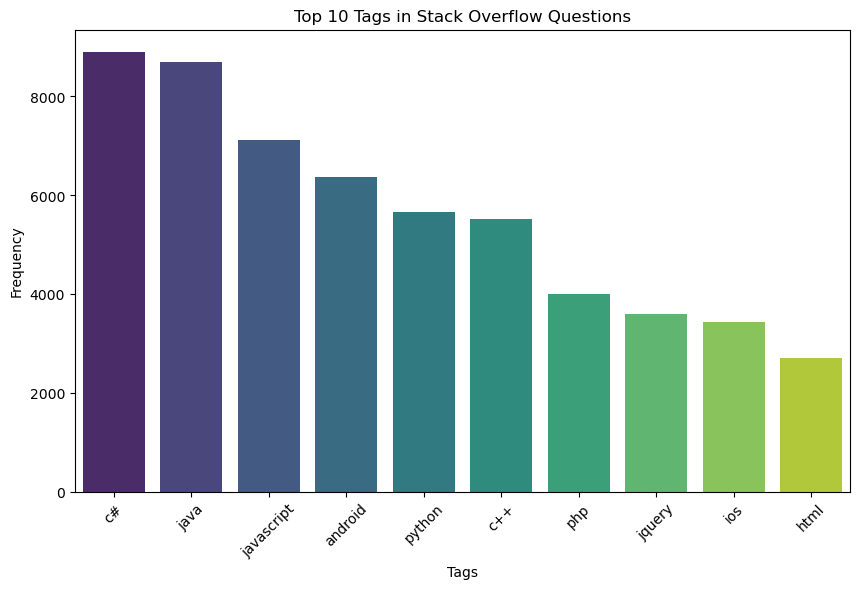

In [334]:
# Visualization of top 10 tags
plt.figure(figsize=(10, 6))
sns.barplot(x=top_tags.index, y=top_tags.values, palette='viridis')
plt.xticks(rotation=45)
plt.title('Top 10 Tags in Stack Overflow Questions')
plt.xlabel('Tags')
plt.ylabel('Frequency')
plt.show()

## Analyzing question length

In [335]:
df_copy = df.copy()
df_copy['Question_Length'] = df_copy['Title'].str.len() + df_copy['Body'].str.len()
top_tags_questions = df_copy[df_copy['Tag'].isin(top_tags.index)]

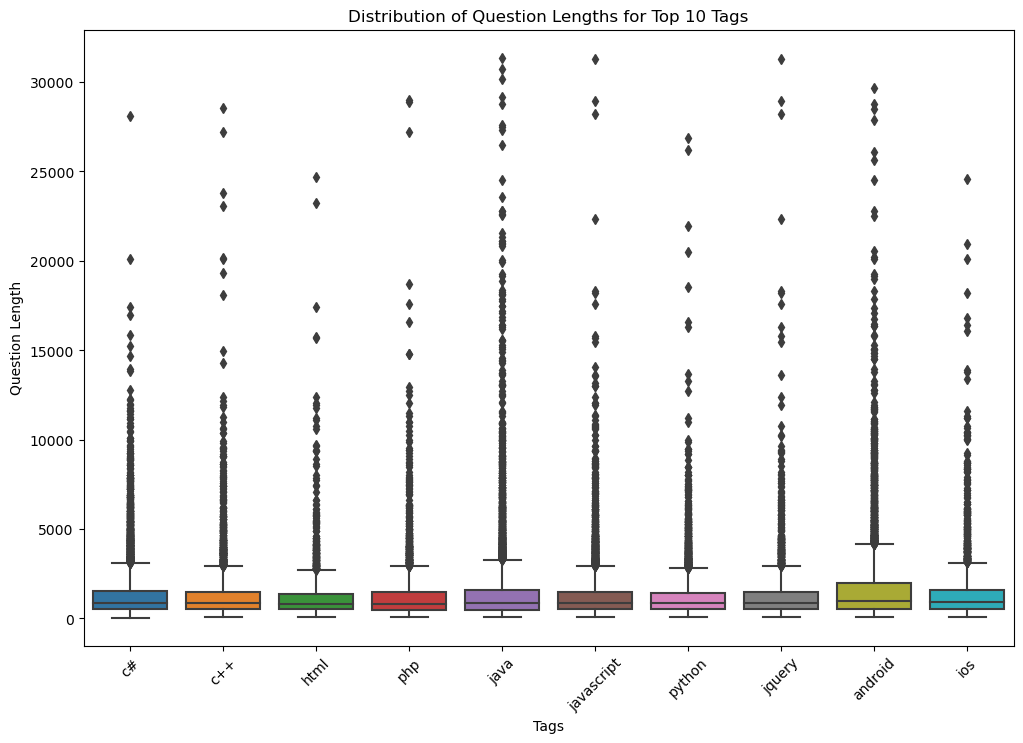

In [336]:
plt.figure(figsize=(12, 8))
sns.boxplot(x='Tag', y='Question_Length', data=top_tags_questions)
plt.xticks(rotation=45)
plt.title('Distribution of Question Lengths for Top 10 Tags')
plt.xlabel('Tags')
plt.ylabel('Question Length')
plt.show()

## Word Cloud for Question Titles

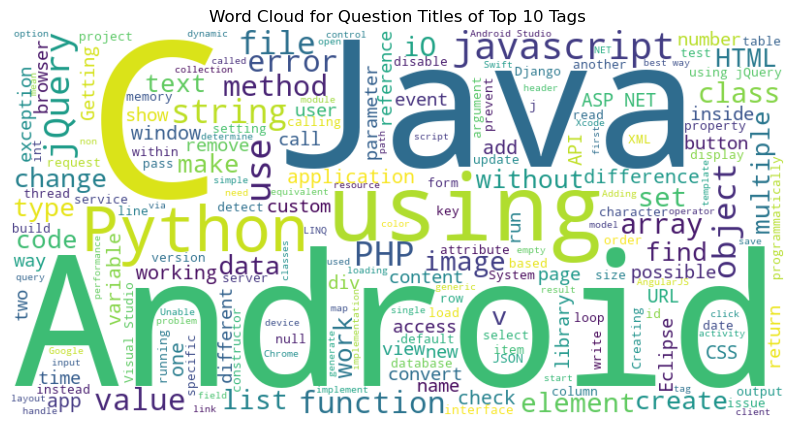

In [337]:
# Concatenate all titles for the top 10 tags
top_tags_titles = ' '.join(top_tags_questions['Title'])

wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(top_tags_titles)

# Display the WordCloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Question Titles of Top 10 Tags')
plt.show()

## Distribution of Title and Body Lengths Separately

In [338]:
df_copy['Title_Length'] = df_copy['Title'].str.len()
df_copy['Body_Length'] = df_copy['Body'].str.len()

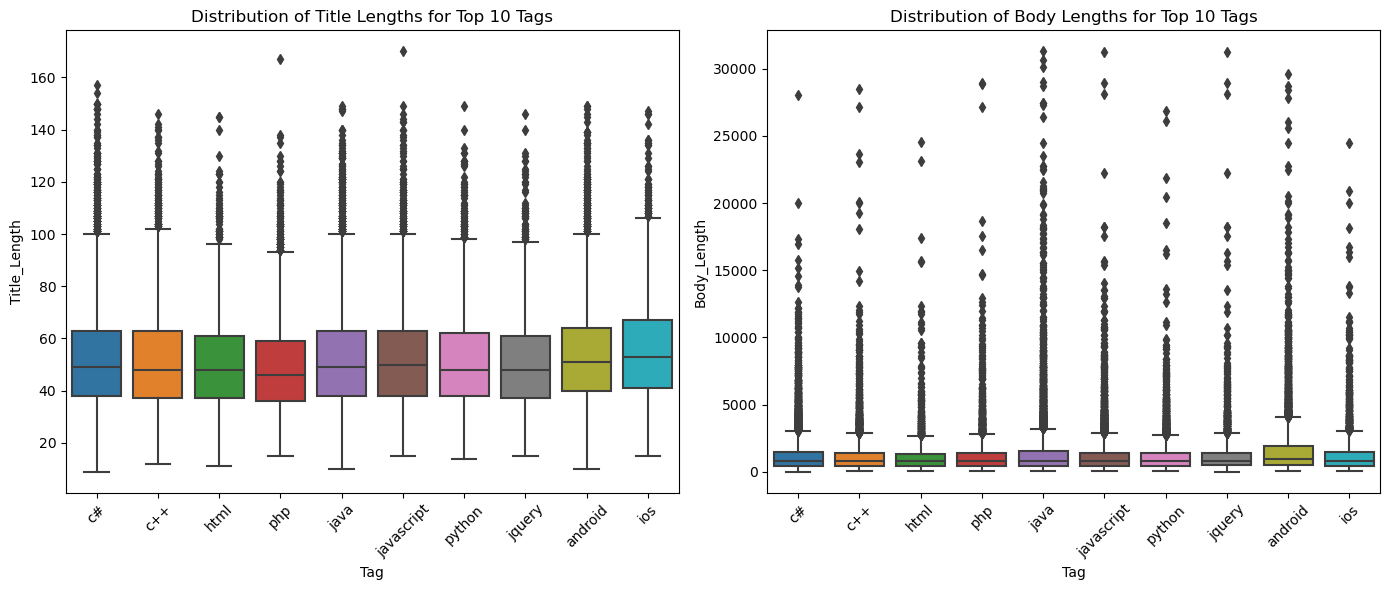

In [339]:
plt.figure(figsize=(14, 6))

# Plotting Title Length Distribution
plt.subplot(1, 2, 1)
sns.boxplot(x='Tag', y='Title_Length', data=df_copy)
plt.xticks(rotation=45)
plt.title('Distribution of Title Lengths for Top 10 Tags')

# Plotting Body Length Distribution
plt.subplot(1, 2, 2)
sns.boxplot(x='Tag', y='Body_Length', data=df_copy)
plt.xticks(rotation=45)
plt.title('Distribution of Body Lengths for Top 10 Tags')

plt.tight_layout()
plt.show()

## Merging answers data frame for more analysis

In [340]:
answers.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [341]:
qa_merged = pd.merge(questions, answers, left_on='Id', right_on='ParentId', how='left', suffixes=('_question', '_answer'), validate='1:m')
qt_merged = pd.merge(questions, tags, on='Id', how='left', validate='1:m')

In [342]:
display_head(qa_merged, qt_merged)

,Id_question,Title,Body_question,Id_answer,OwnerUserId,CreationDate,ParentId,Score,Body_answer
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,124.0,26.0,2008-08-01T16:09:47Z,80.0,12.0,<p>I wound up using this. It is a kind of a ha...
1,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,10008.0,1109.0,2008-08-13T16:09:09Z,80.0,6.0,"<p>The <a href=""http://en.wikipedia.org/wiki/S..."
2,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,3770976.0,364174.0,2010-09-22T15:37:30Z,80.0,1.0,<p>What about making your delimiter something ...
3,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,92.0,61.0,2008-08-01T14:45:37Z,90.0,13.0,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
4,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,202317.0,20709.0,2008-10-14T18:41:45Z,90.0,2.0,"<p>You can also try <em><a href=""http://www.co..."


,Id,Title,Body,Tag
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex
1,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,actionscript-3
2,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,air
3,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn
4,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,tortoisesvn


In [343]:
average_score_by_tag = qa_merged.groupby('Id_question')['Score'].mean().reset_index() 
average_score_by_tag = pd.merge(average_score_by_tag, qt_merged, left_on='Id_question', right_on='Id', how='left')  # Omit validate parameter
average_score_by_tag_per_tag = average_score_by_tag.groupby('Tag')['Score'].mean()  # Aggregate by 'Tag'

print(average_score_by_tag_per_tag.head())

Tag
.bash-profile    10.453333
.class-file       1.000000
.doc              6.750000
.emf              5.333333
.htaccess         8.795701
Name: Score, dtype: float64


## Distribution of answer scores

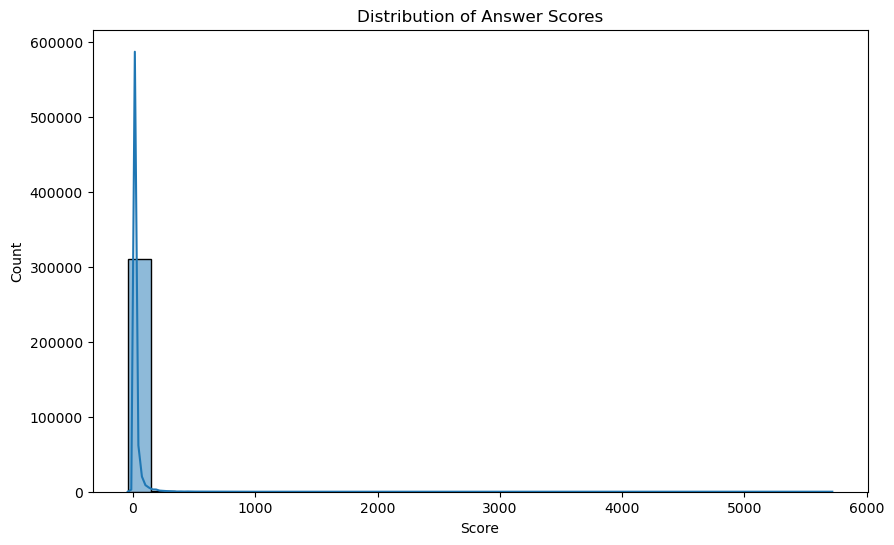

In [344]:
plt.figure(figsize=(10, 6))
sns.histplot(qa_merged['Score'], kde=True, bins=30)
plt.title('Distribution of Answer Scores')
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

## Top Tags by Average Answer Score

In [345]:
avg_score_per_question = qa_merged.groupby('Id_question')['Score'].mean().reset_index(name='Average Score')

# Merge with qt_merged to get tags
avg_score_tags = pd.merge(avg_score_per_question, qt_merged, left_on='Id_question', right_on='Id', how='left')

# Calculate average score per tag
avg_score_per_tag = avg_score_tags.groupby('Tag')['Average Score'].mean().sort_values(ascending=False).reset_index()

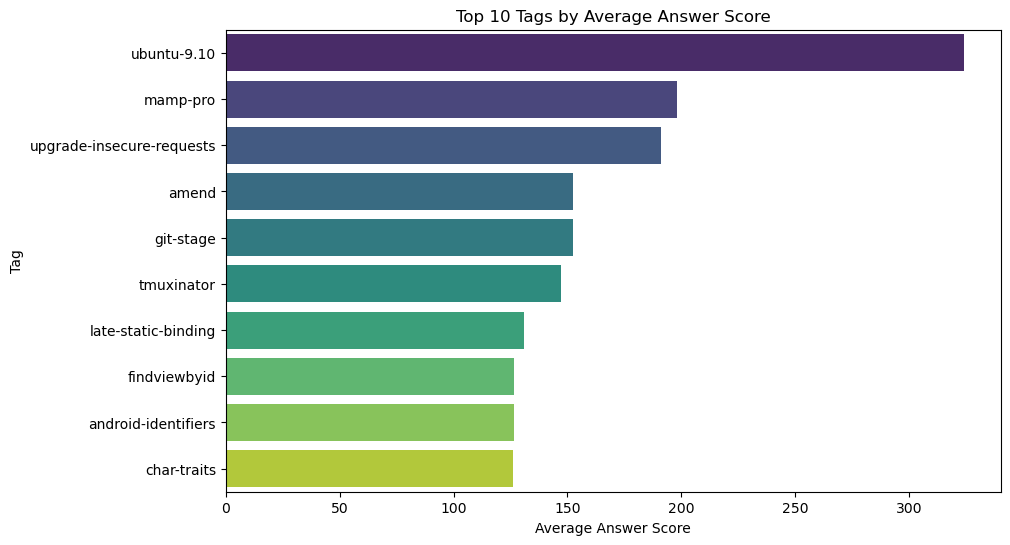

In [346]:
# Visualize top tags by average answer score
plt.figure(figsize=(10, 6))
sns.barplot(x='Average Score', y='Tag', data=avg_score_per_tag.head(10), palette='viridis')
plt.title('Top 10 Tags by Average Answer Score')
plt.xlabel('Average Answer Score')
plt.ylabel('Tag')
plt.show()

## Answer Creation Dates Analysis

In [347]:
qa_merged['CreationDate'] = pd.to_datetime(qa_merged['CreationDate'])

# Extract year for each answer
qa_merged['Year'] = qa_merged['CreationDate'].dt.year

# Count of answers per year
answers_per_year = qa_merged.groupby('Year')['Id_answer'].count().reset_index(name='Answers Count')


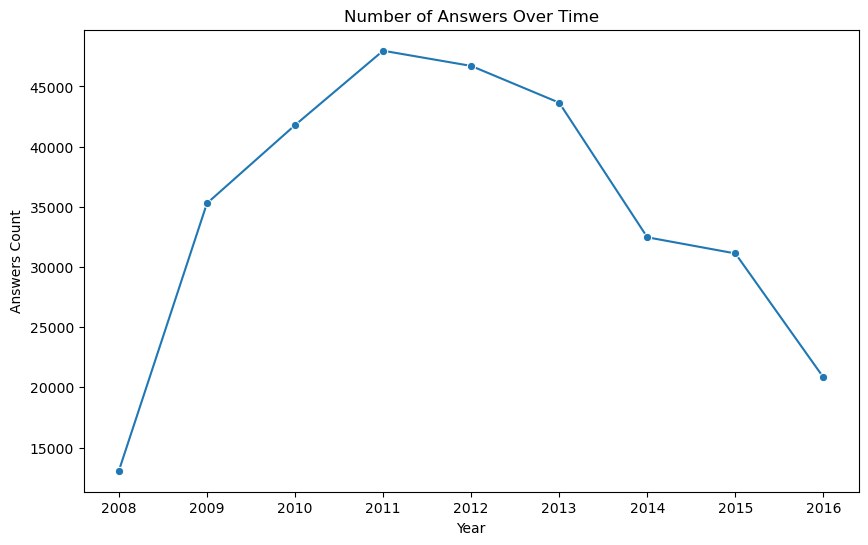

In [348]:
plt.figure(figsize=(10, 6))
sns.lineplot(data=answers_per_year, x='Year', y='Answers Count', marker='o')
plt.title('Number of Answers Over Time')
plt.xlabel('Year')
plt.ylabel('Answers Count')
plt.show()

In [349]:
## Finding top 10 tags based on their frequency of appearance.
top_10_tags = qt_merged['Tag'].value_counts().head(10).index.tolist()
qt_filtered = qt_merged[qt_merged['Tag'].isin(top_10_tags)]


In [350]:
# Aggregate data: Count answers and average score per question
agg_data = qa_merged.groupby('Id_question').agg(Answers_Count=('Id_answer', 'count'), 
                                                Avg_Score=('Score', 'mean')).reset_index()


In [351]:
# Merge aggregated data with qt_filtered to get tag information
tagged_questions = pd.merge(agg_data, qt_filtered, left_on='Id_question', right_on='Id', how='inner')


In [352]:
# Since questions can have multiple tags, they might appear more than once.
tagged_questions_unique = tagged_questions.drop_duplicates(subset='Id_question')

## Average Score per Tag

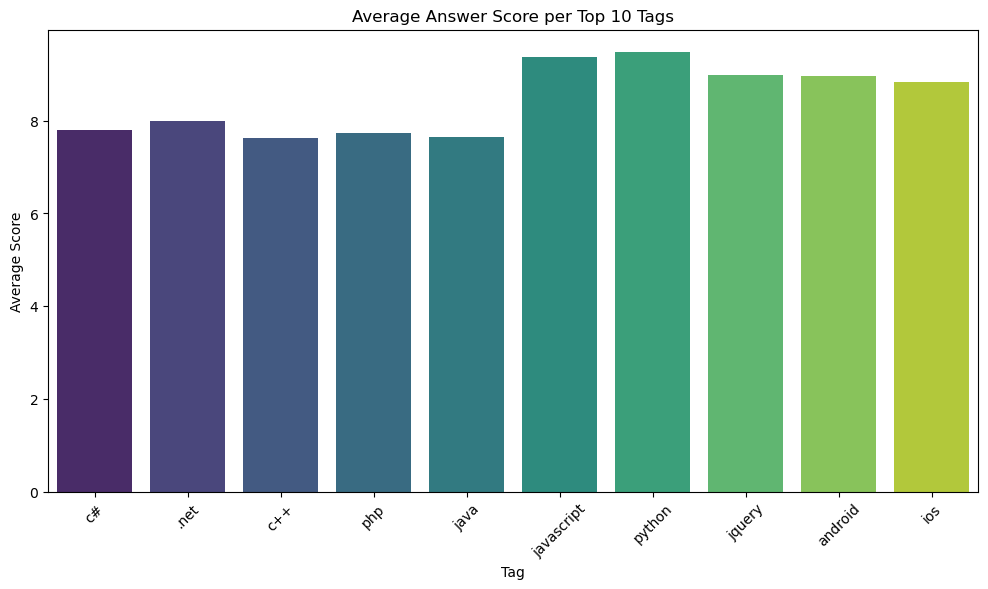

In [353]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Tag', y='Avg_Score', data=tagged_questions, estimator=np.mean, ci=None, palette='viridis')
plt.xticks(rotation=45)
plt.title('Average Answer Score per Top 10 Tags')
plt.ylabel('Average Score')
plt.xlabel('Tag')
plt.show()

## Number of Answers per Tag

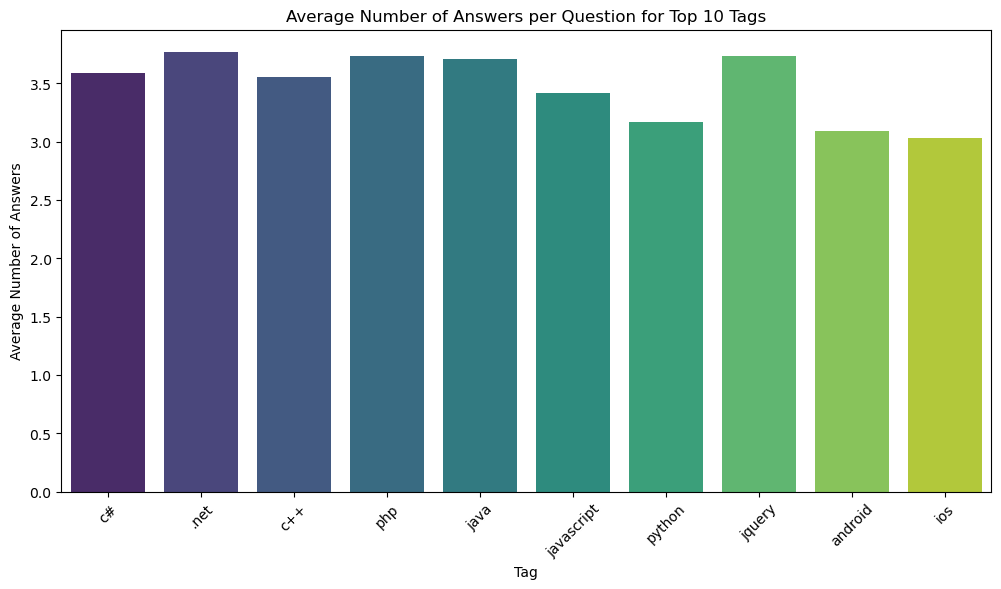

In [354]:
plt.figure(figsize=(12, 6))
sns.barplot(x='Tag', y='Answers_Count', data=tagged_questions, estimator=np.mean, ci=None, palette='viridis')
plt.xticks(rotation=45)
plt.title('Average Number of Answers per Question for Top 10 Tags')
plt.ylabel('Average Number of Answers')
plt.xlabel('Tag')
plt.show()

## Number of Answers per Question for Top 10 Tags

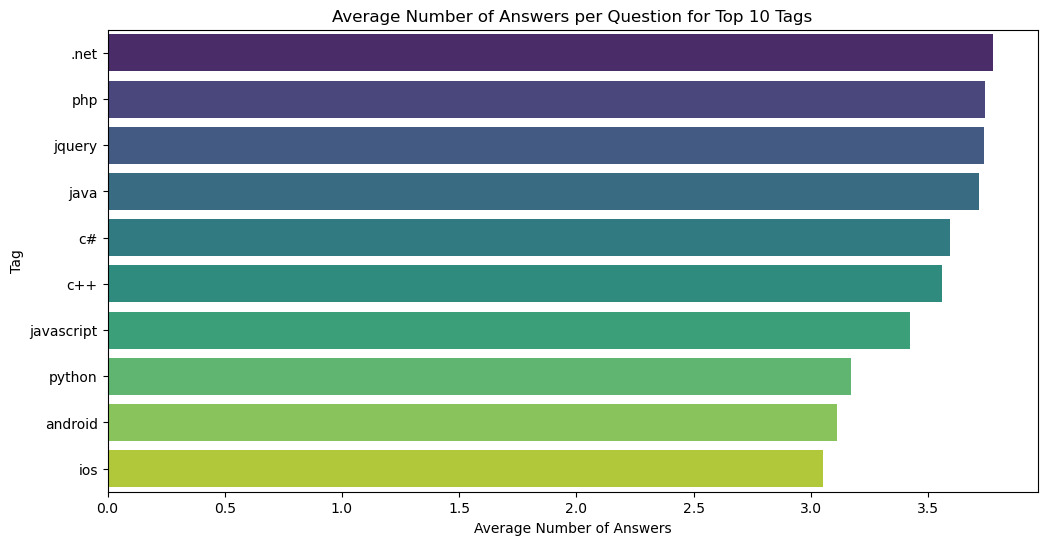

In [355]:
# Count number of answers per question
answers_count_per_question = qa_merged.groupby('Id_question').size().reset_index(name='Answers Count')

# Merge with qt_filtered to relate to tags
qt_answers_count = pd.merge(qt_filtered, answers_count_per_question, left_on='Id', right_on='Id_question', how='left')

# Calculate average number of answers per tag
avg_answers_per_tag = qt_answers_count.groupby('Tag')['Answers Count'].mean().reset_index()

# Visualization
plt.figure(figsize=(12, 6))
sns.barplot(x='Answers Count', y='Tag', data=avg_answers_per_tag.sort_values('Answers Count', ascending=False), palette='viridis')
plt.title('Average Number of Answers per Question for Top 10 Tags')
plt.xlabel('Average Number of Answers')
plt.ylabel('Tag')
plt.show()


## Trend of Questions Over Time for Top 10 Tags

In [356]:
# Merge answers with qt_filtered to get tags for each answer
answers_with_tags = pd.merge(answers[['ParentId', 'CreationDate']], qt_filtered[['Id', 'Tag']], left_on='ParentId', right_on='Id', how='inner')

# Ensure the 'CreationDate' is in datetime format
answers_with_tags['CreationDate'] = pd.to_datetime(answers_with_tags['CreationDate'])

# Extract Year from CreationDate for aggregation
answers_with_tags['Year'] = answers_with_tags['CreationDate'].dt.year

# Aggregate data by Year and Tag to count the number of answers
answers_per_year_per_tag = answers_with_tags.groupby(['Year', 'Tag']).size().reset_index(name='Answers Count')

## Visualize the Trend of Answers Over Time for Top 10 Tags

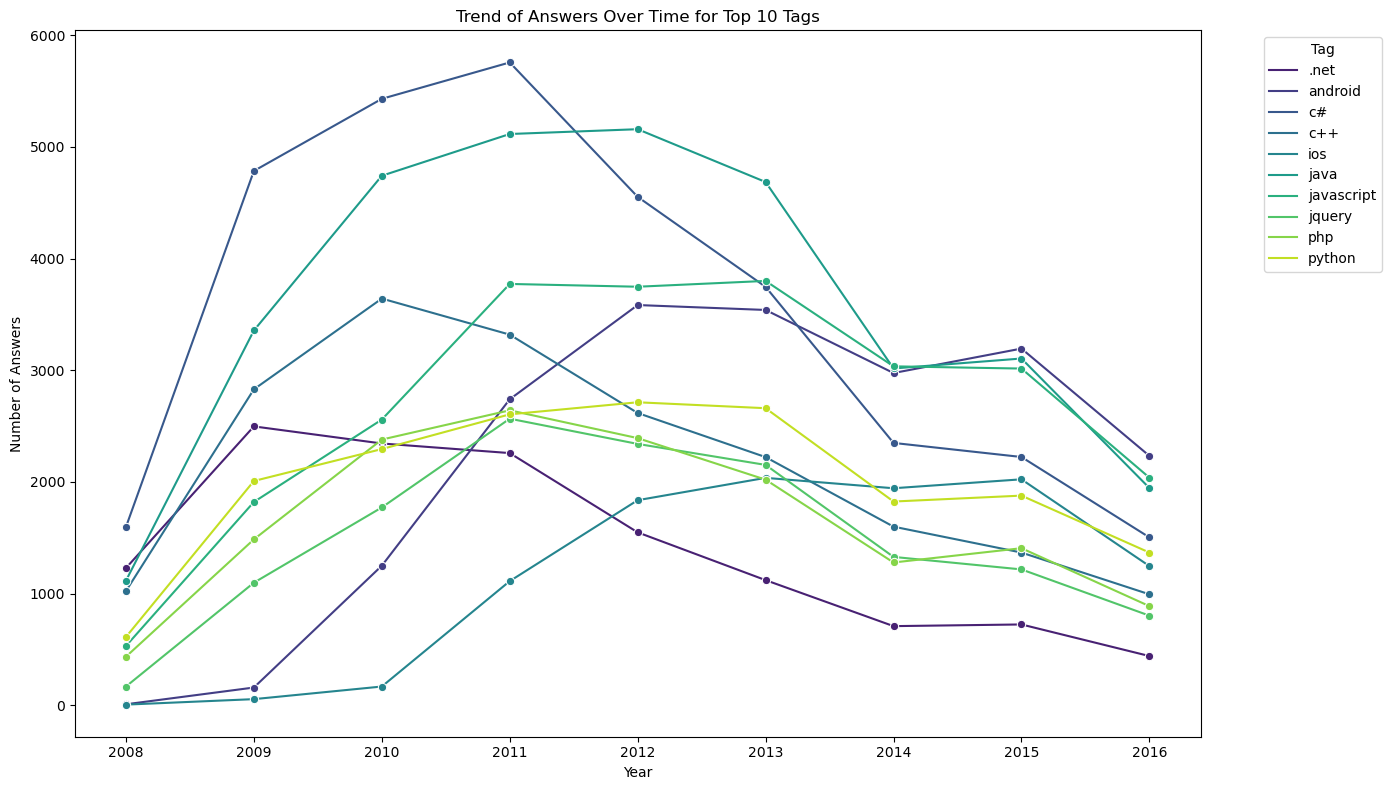

In [357]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=answers_per_year_per_tag, x='Year', y='Answers Count', hue='Tag', marker='o', palette='viridis')
plt.title('Trend of Answers Over Time for Top 10 Tags')
plt.xlabel('Year')
plt.ylabel('Number of Answers')
plt.legend(title='Tag', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Data Preprocessing


## Defining functions that will be used for data preprocessing

In [358]:
def get_emoji_regexp():
    return re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE);

In [359]:
def remove_html_tags(X):
    for column in ['Body', 'Title']:
        X[column] = X[column].apply(lambda x: BeautifulSoup(x, 'html.parser').get_text())
    return X

In [360]:
def clean_text(lines):
    all_reviews = list()
    stop_words = set(stopwords.words('english'))
    for text in lines:
        text = text.lower()
        
        # Remove URLs
        pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
        text = pattern.sub('', text)
        
        # Remove emojis
        text = get_emoji_regexp().sub(r'', text)
        
        # Expanding contractions
        text = contractions.fix(text)
        
        # Remove punctuation
        text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)

        # Tokenization
        tokens = word_tokenize(text)
        
        # filter out non-alphabetic tokens
        tokens = [word for word in tokens if word.isalpha()]
        
        # Joining words to form the cleaned up text
        cleaned_text = ' '.join(tokens)
        all_reviews.append(cleaned_text)
    return all_reviews

## Data Cleaning

In [361]:
tagged_questions = df.groupby('Id').agg({
    'Title': 'first',  # Keep the title of the first occurrence
    'Body': 'first',  # Keep the body of the first occurrence
    'Tag': lambda tags: ','.join(tags)  # Join all tags associated with the ID
}).reset_index()

# Convert Tag column from comma-separated string to list of tags
tagged_questions['Tag'] = tagged_questions['Tag'].apply(lambda x: x.split(','))


In [362]:
df = tagged_questions
df.head()

,Id,Title,Body,Tag
0,260,Adding scripting functionality to .NET applica...,<p>I have a little game written in C#. It uses...,[c#]
1,330,Should I use nested classes in this case?,<p>I am working on a collection of classes use...,[c++]
2,650,Automatically update version number,<p>I would like the version property of my app...,[c#]
3,930,How do I connect to a database and loop over a...,<p>What's the simplest way to connect and quer...,[c#]
4,1010,"How to get the value of built, encoded ViewState?",<p>I need to grab the base64-encoded represent...,[c#]


In [363]:
# Encode the tags
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df['Tag'])
print(y)

[[0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]]


In [364]:
df = remove_html_tags(df)
df.head()

,Id,Title,Body,Tag
0,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,[c#]
1,330,Should I use nested classes in this case?,I am working on a collection of classes used f...,[c++]
2,650,Automatically update version number,I would like the version property of my applic...,[c#]
3,930,How do I connect to a database and loop over a...,What's the simplest way to connect and query a...,[c#]
4,1010,"How to get the value of built, encoded ViewState?",I need to grab the base64-encoded representati...,[c#]


In [365]:
df_combined_featrures = df['Title'] + ". " + df["Body"]
df['Combined'] = df_combined_featrures
df['Combined'] = clean_text(df['Combined'])
df.head()

,Id,Title,Body,Tag,Combined
0,260,Adding scripting functionality to .NET applica...,I have a little game written in C#. It uses a ...,[c#],adding scripting functionality to net applicat...
1,330,Should I use nested classes in this case?,I am working on a collection of classes used f...,[c++],should i use nested classes in this case i am ...
2,650,Automatically update version number,I would like the version property of my applic...,[c#],automatically update version number i would li...
3,930,How do I connect to a database and loop over a...,What's the simplest way to connect and query a...,[c#],how do i connect to a database and loop over a...
4,1010,"How to get the value of built, encoded ViewState?",I need to grab the base64-encoded representati...,[c#],how to get the value of built encoded viewstat...


In [366]:
x_train, x_test, y_train, y_test = train_test_split(tagged_questions['Combined'], y,  test_size=0.2, random_state=42)

In [367]:
display_head(x_train, x_test)

9683     what benefit is there of allowing a variable t...
11313    assertequals does not work without second para...
20482    ios how to set a uiswitch programmatically i w...
19364    what does a in an import statement in python m...
31316    can not search arabic in mysql quran database ...
Name: Combined, dtype: object

4421     how to find the length of an lpcstr i am tryin...
24543    remove an item from an observablecollection in...
3564     c using windows named pipes for some reason bo...
2449     jpa or hibernate for java persistence i am res...
22328    how to get screen metrics outside an activity ...
Name: Combined, dtype: object

In [368]:
# Tokenize and convert to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(x_train)  # Fit only on training data
train_sequences = tokenizer.texts_to_sequences(x_train)
test_sequences = tokenizer.texts_to_sequences(x_test)

In [369]:
word_index = tokenizer.word_index
print("Found %s unique tokens." % len(word_index))

Found 232682 unique tokens.


In [370]:
# Find max length of sequences in train data for padding
max_len = max([len(seq) for seq in train_sequences])

In [371]:
# Pad sequences
x_train = pad_sequences(train_sequences, maxlen=max_len)
x_test = pad_sequences(test_sequences, maxlen=max_len)

In [372]:
# Now, x_train, y_train, x_val, and y_val are ready for model training
print(f'Train data shape: {x_train.shape}')
print(f'Validation data shape: {x_test.shape}')
print(f'Train labels shape: {y_train.shape}')
print(f'Validation labels shape: {y_test.shape}')

Train data shape: (40677, 3785)
Validation data shape: (10170, 3785)
Train labels shape: (40677, 10)
Validation labels shape: (10170, 10)


# Building Models using Glove Embedding

In [159]:
# embedding layer
glove_file = r'glove.840B.300d.txt'
embeddings_index = {}
file = glove_file 
with open(file, encoding='utf8') as file:
    for line in file:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs
        except ValueError:
            print(f"Error converting to float for word: {word} - Skipping line")

print(f'Found {len(embeddings_index)} word vectors.')

Error converting to float for word: . - Skipping line
Error converting to float for word: at - Skipping line
Error converting to float for word: . - Skipping line
Error converting to float for word: to - Skipping line
Error converting to float for word: . - Skipping line
Error converting to float for word: . - Skipping line
Error converting to float for word: email - Skipping line
Error converting to float for word: or - Skipping line
Error converting to float for word: contact - Skipping line
Error converting to float for word: Email - Skipping line
Error converting to float for word: on - Skipping line
Error converting to float for word: At - Skipping line
Error converting to float for word: by - Skipping line
Error converting to float for word: in - Skipping line
Error converting to float for word: emailing - Skipping line
Error converting to float for word: Contact - Skipping line
Error converting to float for word: at - Skipping line
Error converting to float for word: • - Skippin

In [160]:
coefs.shape, coefs

((300,),
 array([-7.9690e-02, -2.2905e-01,  8.0366e-01, -7.8865e-01, -4.0567e-01,
        -1.5716e-01, -4.2302e-01,  6.4081e-01, -1.3215e-01, -1.4109e+00,
         7.3118e-01, -3.7391e-01, -3.6422e-01,  2.4199e-02, -2.4359e-01,
         1.0140e+00,  6.5176e-04, -8.9537e-01,  8.0540e-01, -7.3101e-02,
         2.0257e-01,  5.9553e-01, -3.4971e-03, -2.8126e-01,  5.8631e-01,
        -1.7115e-01,  1.2428e-01,  5.3392e-01,  4.8289e-01,  3.6989e-01,
        -9.1151e-02, -2.3874e-01,  3.8864e-01, -1.6403e-01, -8.5745e-01,
         1.9000e-01,  4.1450e-01,  3.5958e-01, -1.8726e-02,  5.5213e-01,
        -9.1331e-03, -4.8204e-01, -6.4685e-01,  6.1736e-01, -2.7128e-01,
         1.3459e-01,  9.4729e-01, -4.2939e-01, -3.2462e-01, -8.8466e-02,
         3.7337e-01,  2.9062e-01, -7.4411e-03,  1.9840e-01, -4.2686e-01,
        -7.1294e-02, -4.3443e-02, -3.3026e-03, -1.0519e-01,  2.0885e-01,
        -3.0217e-01,  2.7366e-01, -3.5602e-01, -8.9143e-01,  2.8561e-01,
        -1.1656e-01,  2.2460e-01, -2.1561e

In [164]:
# At this point we can leverage our embedding_index dictionary and our word_index to compute our embedding matrix:
embedding_dim = 300
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not foud in embedding index will be all zeros.
        embedding_matrix[i] = embedding_vector
    

In [165]:
embedding_matrix.shape

(232683, 300)

In [175]:
def train_and_evaluate_model(model, model_type, X_train, y_train, X_test, y_test, batch_size=800, epochs=10):
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    callback_list = [
        EarlyStopping(monitor='val_accuracy', patience=5),
        ModelCheckpoint(f'model_{model_type}_{{val_accuracy:.4f}}.h5', save_best_only=True, save_weights_only=False, monitor='val_accuracy')
    ]
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, callbacks=callback_list)
    return history


In [168]:
def plot_metrics(history):
    epochs = len(history.history['loss'])
    plt.figure(figsize=(12, 4))
    for i, metrics in enumerate(zip([history.history['loss'], history.history['accuracy']], 
                                     [history.history['val_loss'], history.history['val_accuracy']], 
                                     ['Loss', 'Accuracy'])):
        plt.subplot(1, 2, i + 1)
        plt.plot(range(epochs), metrics[0], label='Training {}'.format(metrics[2]))
        plt.plot(range(epochs), metrics[1], label='Validation {}'.format(metrics[2]))
        plt.legend()
    plt.show()

In [169]:
def select_and_load_best_model(model_type):
    pattern = rf'model_{model_type}_(.*).h5'  # Raw f-string to handle the regular expression
    models = [f for f in os.listdir() if re.match(pattern, f)]
    best_model = max(models, key=lambda x: float(re.findall(rf"model_{model_type}_(.*).h5", x)[0]))
    print(f"Loading best model: {best_model}")
    return load_model(best_model)

In [172]:
num_classes = y_train.shape[1] 

In [173]:
num_classes

10

In [186]:
embedding_layer = Embedding(len(word_index) + 1,
                           embedding_dim,
                           weights = [embedding_matrix],
                           input_length = max_len,
                           trainable = False)                     

## Building a GRU model using Glove

In [174]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = GRU(128, return_sequences=True)(embedded_sequences)  # return_sequences=True as we're adding more GRU layers
x = Dropout(0.2)(x)  # Adding a dropout layer for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding another dropout layer
x = GRU(64)(x)  # This is the last GRU layer, so it does not return sequences
x = Dropout(0.2)(x)  # Adding dropout for regularization
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='sigmoid')(x)  # Using sigmoid for multi-label classification

model = Model(inputs=sequence_input, outputs=outputs)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 3785)]            0         
                                                                 
 embedding_2 (Embedding)     (None, 3785, 300)         69804900  
                                                                 
 gru_12 (GRU)                (None, 3785, 128)         165120    
                                                                 
 dropout_18 (Dropout)        (None, 3785, 128)         0         
                                                                 
 dense_18 (Dense)            (None, 3785, 128)         16512     
                                                                 
 dropout_19 (Dropout)        (None, 3785, 128)         0         
                                                                 
 gru_13 (GRU)                (None, 64)                3724

In [176]:
model_type = "model_glove"
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_type = f"{model_type}_{timestamp}"
history = train_and_evaluate_model(model, model_type, x_train, y_train, x_test, y_test, batch_size=128, epochs=30)

Epoch 1/30


2024-03-06 22:58:53.428551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 22:58:54.097643: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 22:58:55.259207: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 22:58:56.580429: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 22:58:57.054086: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - ETA: 0s - loss: 0.2728 - accuracy: 0.3981

2024-03-06 23:06:21.097750: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 23:06:21.243438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-06 23:06:22.112438: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 477s 1s/step - loss: 0.2728 - accuracy: 0.3981 - val_loss: 0.1279 - val_accuracy: 0.7509
Epoch 2/30
318/318 [==============================] - 467s 1s/step - loss: 0.1191 - accuracy: 0.7926 - val_loss: 0.0995 - val_accuracy: 0.8105
Epoch 3/30
318/318 [==============================] - 467s 1s/step - loss: 0.0991 - accuracy: 0.8270 - val_loss: 0.0928 - val_accuracy: 0.8240
Epoch 4/30
318/318 [==============================] - 479s 2s/step - loss: 0.0889 - accuracy: 0.8444 - val_loss: 0.0876 - val_accuracy: 0.8341
Epoch 5/30
318/318 [==============================] - 472s 1s/step - loss: 0.0828 - accuracy: 0.8565 - val_loss: 0.0864 - val_accuracy: 0.8341
Epoch 6/30
318/318 [==============================] - 474s 1s/step - loss: 0.0770 - accuracy: 0.8691 - val_loss: 0.0877 - val_accuracy: 0.8379
Epoch 7/30
318/318 [==============================] - 467s 1s/step - loss: 0.0720 - accuracy: 0.8775 - val_loss: 0.0893 - val_accuracy: 0.8372
Epoch 8/30

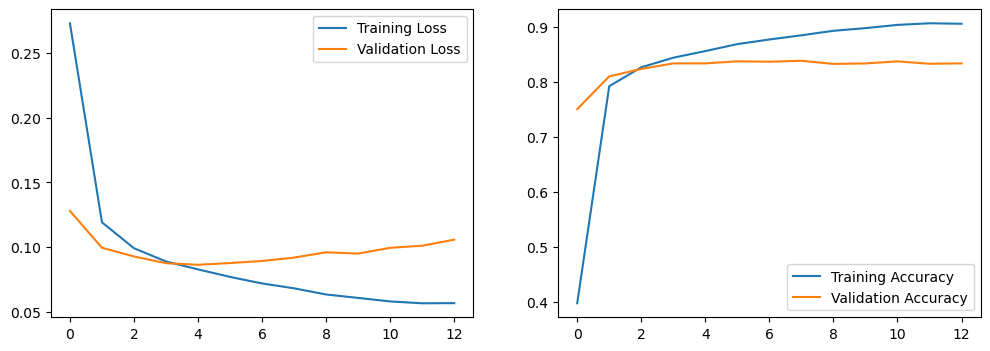

In [177]:
plot_metrics(history)

In [178]:
# Automatically select and load the best model
best_model_1 = select_and_load_best_model(model_type)

Loading best model: model_model_glove_2024-03-06_22-58-51_0.8388.h5


In [179]:
# Make predictions with the best model
preds = best_model_1.predict(x_test)

2024-03-07 00:46:42.908315: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:46:43.026364: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:46:43.284148: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 53s 165ms/step


In [180]:
threshold = 0.5
preds_binary = (preds >= threshold).astype(int)

In [185]:
# Calculate metrics
precision = precision_score(y_test, preds_binary, average='macro')
recall = recall_score(y_test, preds_binary, average='macro')
f1 = f1_score(y_test, preds_binary, average='macro')

print(f"Precision (Macro-average): {precision}")
print(f"Recall (Macro-average): {recall}")
print(f"F1 Score (Macro-average): {f1}")

# Detailed classification report
print(classification_report(y_test, preds_binary, target_names=mlb.classes_))

Precision (Macro-average): 0.8729005052961097
Recall (Macro-average): 0.8214626845861404
F1 Score (Macro-average): 0.8434611267156564
              precision    recall  f1-score   support

     android       0.96      0.89      0.93      1223
          c#       0.87      0.83      0.85      1845
         c++       0.86      0.83      0.84      1097
        html       0.81      0.53      0.64       555
         ios       0.89      0.91      0.90       644
        java       0.88      0.85      0.86      1718
  javascript       0.76      0.84      0.80      1436
      jquery       0.81      0.79      0.80       674
         php       0.92      0.83      0.88       781
      python       0.96      0.91      0.94      1172

   micro avg       0.87      0.84      0.85     11145
   macro avg       0.87      0.82      0.84     11145
weighted avg       0.87      0.84      0.85     11145
 samples avg       0.87      0.86      0.86     11145



## Building a Bidirectional GRU model using Glove

In [188]:
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
x = Bidirectional(GRU(128, return_sequences=True))(embedded_sequences)  # return_sequences=True as we're adding more GRU layers
x = Dropout(0.2)(x)  # Adding a dropout layer for regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)  # Adding another dropout layer
x = Bidirectional(GRU(64))(x)  # This is the last GRU layer, so it does not return sequences
x = Dropout(0.2)(x)  # Adding dropout for regularization
x = Dense(64, activation='relu')(x)
outputs = Dense(num_classes, activation='sigmoid')(x)  # Using sigmoid for multi-label classification

model = Model(inputs=sequence_input, outputs=outputs)
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 3785)]            0         
                                                                 
 embedding_3 (Embedding)     (None, 3785, 300)         69804900  
                                                                 
 bidirectional_5 (Bidirecti  (None, 3785, 256)         330240    
 onal)                                                           
                                                                 
 dropout_24 (Dropout)        (None, 3785, 256)         0         
                                                                 
 dense_24 (Dense)            (None, 3785, 128)         32896     
                                                                 
 dropout_25 (Dropout)        (None, 3785, 128)         0         
                                                           

In [189]:
model_type = "model_glove_bi_gru"
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
model_type = f"{model_type}_{timestamp}"
history = train_and_evaluate_model(model, model_type, x_train, y_train, x_test, y_test, batch_size=128, epochs=30)

Epoch 1/30


2024-03-07 00:57:05.584811: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:57:06.124141: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:57:06.384241: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:57:09.007417: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:57:09.101270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:57:09.804854: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 00:57:09.828226: I tensorflow/core/grappler/optimizers/cust

318/318 [==============================] - ETA: 0s - loss: 0.2948 - accuracy: 0.3307

2024-03-07 01:18:05.785189: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 01:18:05.958895: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 01:18:06.080545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 01:18:07.496605: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 01:18:07.545099: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 1318s 4s/step - loss: 0.2948 - accuracy: 0.3307 - val_loss: 0.1594 - val_accuracy: 0.7138
Epoch 2/30
318/318 [==============================] - 1312s 4s/step - loss: 0.1269 - accuracy: 0.7812 - val_loss: 0.1006 - val_accuracy: 0.8120
Epoch 3/30
318/318 [==============================] - 1351s 4s/step - loss: 0.0980 - accuracy: 0.8297 - val_loss: 0.0914 - val_accuracy: 0.8255
Epoch 4/30
318/318 [==============================] - 1414s 4s/step - loss: 0.0870 - accuracy: 0.8462 - val_loss: 0.0865 - val_accuracy: 0.8355
Epoch 5/30
318/318 [==============================] - 995s 3s/step - loss: 0.0789 - accuracy: 0.8600 - val_loss: 0.0862 - val_accuracy: 0.8394
Epoch 6/30
318/318 [==============================] - 1008s 3s/step - loss: 0.0726 - accuracy: 0.8707 - val_loss: 0.0830 - val_accuracy: 0.8426
Epoch 7/30
318/318 [==============================] - 1001s 3s/step - loss: 0.0672 - accuracy: 0.8790 - val_loss: 0.0839 - val_accuracy: 0.8416
Epoc

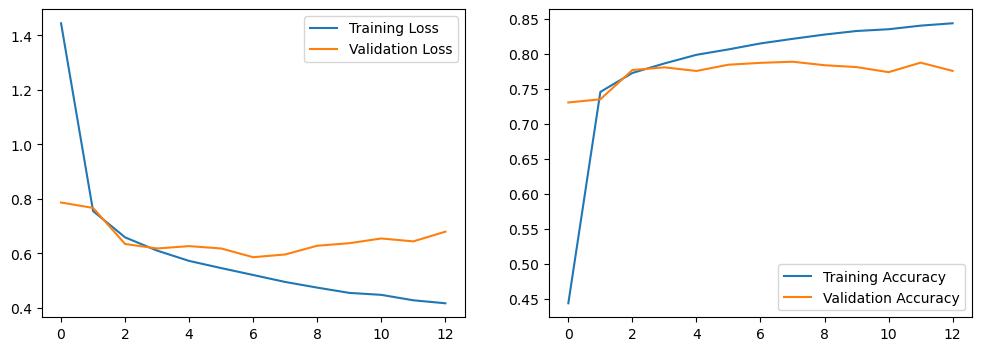

In [73]:
plot_metrics(history)

In [190]:
# Automatically select and load the best model
best_model_2 = select_and_load_best_model(model_type)

Loading best model: model_model_glove_bi_gru_2024-03-07_00-57-03_0.8426.h5


In [191]:
# Make predictions with the best model
preds_2 = best_model_2.predict(x_test)

2024-03-07 10:15:26.646072: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 10:15:26.854355: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 10:15:26.882807: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 10:15:27.554227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-03-07 10:15:27.566613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


318/318 [==============================] - 105s 327ms/step


In [193]:
threshold = 0.5
preds_binary = (preds_2 >= threshold).astype(int)

In [194]:
# Calculate metrics
precision = precision_score(y_test, preds_binary, average='macro')
recall = recall_score(y_test, preds_binary, average='macro')
f1 = f1_score(y_test, preds_binary, average='macro')

print(f"Precision (Macro-average): {precision}")
print(f"Recall (Macro-average): {recall}")
print(f"F1 Score (Macro-average): {f1}")

# Detailed classification report
print(classification_report(y_test, preds_binary, target_names=mlb.classes_))

Precision (Macro-average): 0.8891414391945893
Recall (Macro-average): 0.8052366988900264
F1 Score (Macro-average): 0.8419028523838538
              precision    recall  f1-score   support

     android       0.93      0.92      0.92      1223
          c#       0.83      0.87      0.85      1845
         c++       0.91      0.78      0.84      1097
        html       0.80      0.52      0.63       555
         ios       0.90      0.88      0.89       644
        java       0.92      0.84      0.87      1718
  javascript       0.83      0.76      0.80      1436
      jquery       0.89      0.69      0.78       674
         php       0.91      0.87      0.89       781
      python       0.97      0.91      0.94      1172

   micro avg       0.89      0.83      0.86     11145
   macro avg       0.89      0.81      0.84     11145
weighted avg       0.89      0.83      0.85     11145
 samples avg       0.87      0.85      0.86     11145



# Conclusion

In this analysis, we explored the application of GloVe embeddings in conjunction with two types of neural network models: a GRU model and a Bidirectional GRU model, aimed at classifying text data into specific categories. Our objective was to determine the effectiveness of these models on a multi-class text classification task. The performance of each model was evaluated based on Precision, Recall, and F1 Score, considering both macro-average and specific metrics per category.

**GRU Model Performance:**
The GRU model achieved a macro-average precision of approximately 0.873, recall of 0.821, and an F1 score of 0.843. This model showed particularly strong performance in categorizing 'android' and 'python' questions, with precision scores of 0.96 for both categories. However, it was less effective in handling 'html' questions, indicating potential areas for model improvement.

**Bidirectional GRU Model Performance:**
The Bidirectional GRU model, on the other hand, presented a slightly different performance profile. It achieved a macro-average precision of about 0.889, recall of 0.805, and an F1 score of 0.842. This model excelled in the 'python' category with a high precision score of 0.97 but showed limitations in adequately capturing the 'html' and 'jquery' categories, as evidenced by their lower recall rates.

**Comparative Insights:**
- **Precision and Recall Trade-off:** Both models demonstrated a trade-off between precision and recall, a common phenomenon in classification tasks. The Bidirectional GRU model exhibited higher precision overall, suggesting it is less prone to false positives, whereas the GRU model showed better recall, indicating its strength in identifying relevant instances across categories.

- **Model Complexity and Performance:** The Bidirectional GRU model, with its ability to capture information from both past and future states, did not significantly outperform the standard GRU model in terms of F1 score. This suggests that for this specific task, the additional complexity of a bidirectional architecture might not yield proportional benefits in performance, considering the computational overhead.

- **Category-Specific Performance:** Both models struggled with the 'html' category, which might indicate challenges related to the specificity of language used in HTML-related questions or the similarity of HTML questions with other categories, requiring further investigation into feature engineering or model architecture adjustments.

**Conclusion:**
The analysis demonstrates the efficacy of using GloVe embeddings with GRU-based models for text classification tasks. While both models achieved commendable performance, there remains room for optimization, especially in balancing precision and recall and enhancing category-specific accuracy. Future efforts should aim to refine these models, considering the trade-offs between model complexity and performance, to achieve more robust and computationally efficient text classification systems.